In [24]:
import json
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
# Fonction pour lire les données de transcription
def read_transcription(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

# Fonction pour lire les données du graphe de discours
def read_discourse_graph(file_path):
    with open(file_path, 'r') as file:
        data = [line.strip().split() for line in file]

    # Convertir les valeurs non numériques en indices numériques
    data = [(int(start), relation, int(end)) if start.isdigit() and end.isdigit() else (start, relation, end) for start, relation, end in data]

    return data

def create_dataframe(dialogue_id, transcription, discourse_graph, relation_dict, speaker_dict):
    rows = []

      # Iterate through all edges in the discourse graph
    for edge in discourse_graph:
        index_start, relation_type, index_end = edge

        # Retrieve speaker information
        speaker = transcription[index_start]['speaker']

        # Convert relation type to integer using the dictionary
        speaker_id = speaker_dict.get(speaker, -1)

        # Retrieve the sentence
        text = transcription[index_start]['text']

        # Convert relation type to integer using the dictionary
        relation_type_id = relation_dict.get(relation_type, -1)

        # Add a row to the DataFrame
        rows.append({
            'dialogue_id': dialogue_id,
            'index_start': index_start,
            'text': text,
            'index_end': index_end,
            'speaker_type': speaker_id,
            'speaker_text': speaker,
            'relation_type': relation_type_id,
            'relation_text': relation_type
        })

    # Create the DataFrame
    df = pd.DataFrame(rows)

    return df


# Fonction pour créer le dictionnaire de conversion des relations
def create_relation_dict(discourse_graph):
    relation_set = set()

    # Collecter toutes les relations uniques
    for edge in discourse_graph:
        relation_set.add(edge[1])

    # Créer un dictionnaire de conversion
    relation_dict = {relation: idx for idx, relation in enumerate(relation_set)}

    return relation_dict

# Fonction pour créer le dictionnaire de conversion des speakers
def create_speaker_dict(transcription):
    speaker_set = set()

    # Collecter tous les locuteurs uniques
    for utterance in transcription:
        speaker_set.add(utterance['speaker'])

    # Créer un dictionnaire de conversion
    speaker_dict = {speaker: idx for idx, speaker in enumerate(speaker_set)}

    return speaker_dict

def flatten(list_of_list):
    return [item for sublist in list_of_list for item in sublist]

# Function to get labels for a dialogue
def get_label(dialogue_id, index,labels_data):
    return labels_data.get(dialogue_id, [])[index]


In [26]:
# Remplacez 'votre_chemin' par le chemin correct
chemin_dossier = Path("data/training")

# Remplacez 'vos_dialogue_ids' par votre liste réelle d'identifiants de dialogue
dialogue_ids = ['ES2002', 'ES2005', 'ES2006', 'ES2007', 'ES2008', 'ES2009', 'ES2010', 'ES2012', 'ES2013', 'ES2015', 'ES2016', 'IS1000', 'IS1001', 'IS1002', 'IS1003', 'IS1004', 'IS1005', 'IS1006', 'IS1007', 'TS3005', 'TS3008', 'TS3009', 'TS3010', 'TS3011', 'TS3012']
dialogue_ids = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in dialogue_ids])
dialogue_ids.remove('IS1002a')
dialogue_ids.remove('IS1005d')
dialogue_ids.remove('TS3012c')

# Liste pour stocker les DataFrames de chaque dialogue
dfs = []

In [27]:
# Liste pour stocker les DataFrames de chaque dialogue
dfs = []

# Parcourir chaque dialogue
for dialogue_id in dialogue_ids:
    # Lire les données de transcription et de graphe de discours
    transcription = read_transcription(chemin_dossier / f'{dialogue_id}.json')
    discourse_graph = read_discourse_graph(chemin_dossier / f'{dialogue_id}.txt')
    
    # Créer le dictionnaire de conversion des relations
    relation_dict = create_relation_dict(discourse_graph)
    speaker_dict = create_speaker_dict(transcription)

    # Créer le DataFrame pour le dialogue actuel
    df = create_dataframe(dialogue_id, transcription, discourse_graph, relation_dict, speaker_dict)
    
    # Ajouter le DataFrame à la liste
    dfs.append(df)

In [28]:
# Concaténer tous les DataFrames en un seul
df = pd.concat(dfs, ignore_index=True)

with open("data/training_labels.json", 'r') as file:
    labels_data = json.load(file)

df['label'] = df.apply(lambda row: get_label(row['dialogue_id'], row['index_start'], labels_data), axis=1)


# Afficher le DataFrame final
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72526 entries, 0 to 72525
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   dialogue_id    72526 non-null  object
 1   index_start    72526 non-null  int64 
 2   text           72526 non-null  object
 3   index_end      72526 non-null  int64 
 4   speaker_type   72526 non-null  int64 
 5   speaker_text   72526 non-null  object
 6   relation_type  72526 non-null  int64 
 7   relation_text  72526 non-null  object
 8   label          72526 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 5.0+ MB


,dialogue_id,index_start,text,index_end,speaker_type,speaker_text,relation_type,relation_text,label
0,ES2002a,0,Okay,1,3,PM,1,Continuation,0
1,ES2002a,1,Right,2,3,PM,1,Continuation,0
2,ES2002a,2,<vocalsound> Um well this is the kick-off meet...,3,3,PM,0,Explanation,1
3,ES2002a,3,Um <vocalsound> and um,4,3,PM,2,Elaboration,0
4,ES2002a,4,this is just what we're gonna be doing over th...,5,3,PM,1,Continuation,0


In [29]:
for transcription_id in dialogue_ids:
    bert_array = np.load('training/' + transcription_id + '.npy')
    
    # Obtenez les indices des lignes correspondant à la transcription_id
    indices = df[df['dialogue_id'] == transcription_id].index
    
    # Remplacez les valeurs de la colonne 'text' par les valeurs de bert_array
    for idx, value in enumerate(bert_array):
        df.at[indices[idx-1], 'text'] = value


In [30]:
df.head()

,dialogue_id,index_start,text,index_end,speaker_type,speaker_text,relation_type,relation_text,label
0,ES2002a,0,"[-0.054861926, 0.047606602, -0.032625835, -0.0...",1,3,PM,1,Continuation,0
1,ES2002a,1,"[-0.054665036, -0.073837034, -0.017160872, -0....",2,3,PM,1,Continuation,0
2,ES2002a,2,"[-0.010415948, -0.072719134, -0.017205587, -0....",3,3,PM,0,Explanation,1
3,ES2002a,3,"[-0.028653603, -0.01515074, 0.095909655, -0.05...",4,3,PM,2,Elaboration,0
4,ES2002a,4,"[-0.028386272, -0.046021443, 0.023957256, -0.0...",5,3,PM,1,Continuation,0


In [31]:
# Nombre d'éléments dans chaque liste
num_elements = len(df['text'].iloc[0])

# Créez de nouvelles colonnes pour chaque élément dans la liste
new_columns = [f'coord_{i}' for i in range(num_elements)]

# Appliquez une fonction qui divise chaque liste en plusieurs colonnes
new_text_columns = df['text'].apply(pd.Series)

# Renommez les nouvelles colonnes avec les noms spécifiques
new_text_columns.columns = new_columns

# Concaténez les nouvelles colonnes avec le DataFrame existant
df = pd.concat([df, new_text_columns], axis=1)

# Supprimez la colonne 'text' originale si nécessaire
df = df.drop(['text','speaker_text','relation_text' ], axis=1)


In [32]:
df.head()

,dialogue_id,index_start,index_end,speaker_type,relation_type,label,coord_0,coord_1,coord_2,coord_3,...,coord_374,coord_375,coord_376,coord_377,coord_378,coord_379,coord_380,coord_381,coord_382,coord_383
0,ES2002a,0,1,3,1,0,-0.054862,0.047607,-0.032626,-0.010949,...,0.092259,0.034839,-0.021490,0.007297,0.027587,0.027128,0.145950,0.037911,0.073511,0.079932
1,ES2002a,1,2,3,1,0,-0.054665,-0.073837,-0.017161,-0.064276,...,0.035382,0.098955,-0.025984,0.077994,0.003580,0.032260,0.022304,0.059096,-0.036019,-0.008820
2,ES2002a,2,3,3,0,1,-0.010416,-0.072719,-0.017206,-0.088992,...,0.006533,0.032185,0.010955,0.041298,-0.018026,0.050856,0.007696,0.041694,0.077368,-0.037393
3,ES2002a,3,4,3,2,0,-0.028654,-0.015151,0.095910,-0.059113,...,0.108833,0.061266,-0.011521,-0.010543,0.010692,0.117780,-0.017561,-0.028903,0.007401,-0.005552
4,ES2002a,4,5,3,1,0,-0.028386,-0.046021,0.023957,-0.064278,...,0.111571,-0.023915,-0.037931,0.040358,0.079421,-0.018038,0.041037,0.034134,0.028470,-0.012039


In [33]:
df['diff_index'] = df['index_end'] - df['index_start']

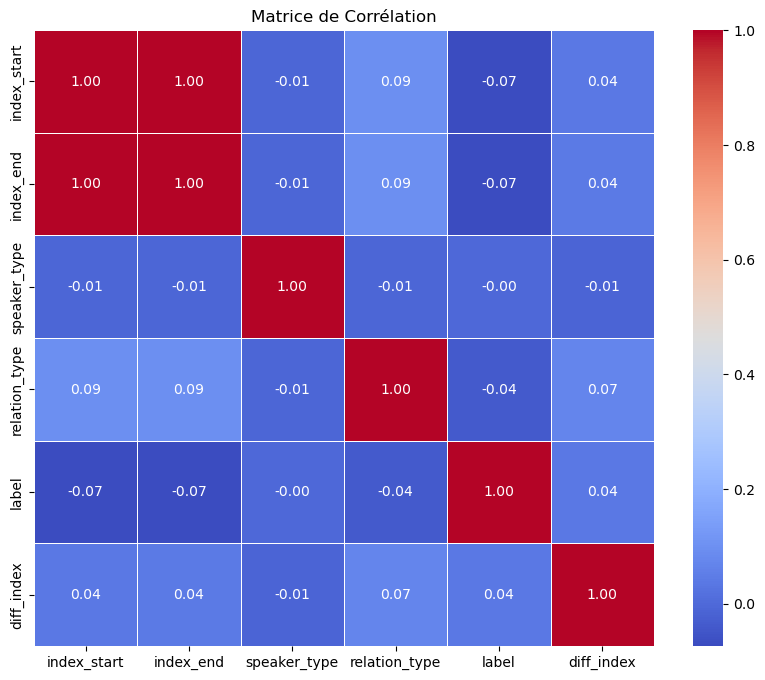

In [34]:
# Sélectionner les colonnes pour la matrice de corrélation
selected_columns = ['index_start', 'index_end', 'speaker_type', 'relation_type', 'label', 'diff_index']

# Créer un sous-dataframe avec les colonnes sélectionnées
corr_df = df[selected_columns]

# Calculer la matrice de corrélation
correlation_matrix = corr_df.corr()

# Tracer la matrice de corrélation colorée
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matrice de Corrélation')
plt.show()

In [53]:
from sklearn.model_selection import train_test_split
# Supprimer les colonnes non nécessaires de X_train (dialogue_id, index_start, index_end, etc.)
X = df.drop(['dialogue_id', 'index_start', 'index_end', 'label'], axis=1)

# Sélectionner la colonne 'label' comme y_train
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)


       speaker_type  relation_type   coord_0   coord_1   coord_2   coord_3  \
230               3             11 -0.071181 -0.039629 -0.023627 -0.044115   
24381             0              2  0.021770  0.006194 -0.064913 -0.036768   
9739              1              1 -0.068377 -0.086527 -0.100196 -0.010274   
62224             3              5 -0.122898 -0.042610  0.004320 -0.011730   
18574             1              1 -0.038015  0.017778 -0.022536 -0.002325   
...             ...            ...       ...       ...       ...       ...   
15922             1              1  0.006400 -0.036309  0.013391  0.008313   
28555             2              1 -0.020296 -0.033322 -0.001082 -0.065680   
27545             2              2  0.031752 -0.003433 -0.030990  0.022442   
5681              3              2  0.056683  0.012518  0.047335  0.008865   
64776             1              4 -0.048652  0.054733  0.011691 -0.014780   

        coord_4   coord_5   coord_6   coord_7  ...  coord_375  

In [62]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout, Input

model = Sequential()
model.add(Input(387))
model.add(Dense(512, activation='relu'))  # Couche cachée avec 512 neurones
model.add(Dropout(0.5))  # Dropout pour la régularisation
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 512)               198656    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 256)               131328    
                                                                 
 dense_16 (Dense)            (None, 2)                 514       
                                                                 
Total params: 330498 (1.26 MB)
Trainable params: 330498 (1.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [63]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [64]:
model.fit(X_train, y_train, epochs=6, batch_size=32, validation_split=0.2)


Epoch 1/6
1270/1270 [==============================] - 5s 4ms/step - loss: 0.5566 - accuracy: 0.7549 - val_loss: 0.5530 - val_accuracy: 0.7565
Epoch 2/6
1270/1270 [==============================] - 5s 4ms/step - loss: 0.5456 - accuracy: 0.7558 - val_loss: 0.5478 - val_accuracy: 0.7563
Epoch 3/6
1270/1270 [==============================] - 4s 3ms/step - loss: 0.5423 - accuracy: 0.7561 - val_loss: 0.5466 - val_accuracy: 0.7540
Epoch 4/6
1270/1270 [==============================] - 4s 3ms/step - loss: 0.5393 - accuracy: 0.7570 - val_loss: 0.5441 - val_accuracy: 0.7566
Epoch 5/6
1270/1270 [==============================] - 4s 3ms/step - loss: 0.5358 - accuracy: 0.7575 - val_loss: 0.5444 - val_accuracy: 0.7547
Epoch 6/6
1270/1270 [==============================] - 4s 3ms/step - loss: 0.5326 - accuracy: 0.7589 - val_loss: 0.5473 - val_accuracy: 0.7551


In [65]:
y_pred = model.predict(X_test)
y_pred_class = np.argmax(y_pred,axis=1)


680/680 [==============================] - 1s 1ms/step


In [67]:
from sklearn.metrics import f1_score
print("F1-score:", f1_score(y_test, y_pred_class))


F1-score: 0.05687036382903568


In [95]:
import shap
# Créer une fonction pour obtenir les prédictions du modèle
def predict_function(X):
    return model.predict(X)

# Créer un explainer SHAP avec la fonction de prédiction et les données d'entraînement
explainer = shap.Explainer(predict_function, np.random.randn(10, 387))

# Générer les valeurs SHAP
shap_values = explainer.shap_values(X_train)



TypeError: PermutationExplainer.shap_values() got an unexpected keyword argument 'n_jobs'

TypeError: only integer scalar arrays can be converted to a scalar index

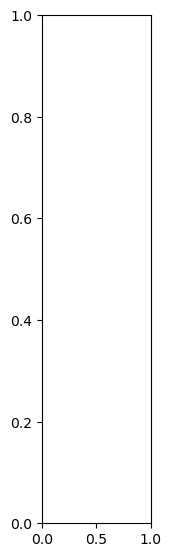

In [90]:
# Afficher les valeurs SHAP
feature_list = [0,1]
shap.summary_plot(shap_values, feature_names=feature_list, plot_size=(15, 8))

shap_values = explainer.shap_values(X_test,nsamples=100)
